# Structure Analysis: Discourse Coherence
Sentence-BERT embeddings, cosine similarity between consecutive sentences. Features: mean/std/min coherence, coherence drops, topic drift. Random Forest classifier.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from scipy.spatial.distance import cosine
from scipy.ndimage import uniform_filter
import nltk
from nltk.tokenize import sent_tokenize
from tqdm import tqdm
import torch
import warnings
warnings.filterwarnings('ignore')

try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt', quiet=True)
    nltk.download('punkt_tab', quiet=True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')
sns.set_style('whitegrid')

c:\Users\orbi8\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


Load merged dataset.

In [2]:
source_path = '../../data_analysis/data.parquet'
df_raw = pd.read_parquet(source_path)

features_expanded = pd.json_normalize(df_raw['feature_cache'])
df = pd.concat([df_raw[['id', 'class', 'topic', 'text']].reset_index(drop=True),
                features_expanded[['author']].reset_index(drop=True)], axis=1)

print(f'Loaded {len(df)} rows')
print('Class distribution:')
print(df['class'].value_counts())

Loaded 1508 rows
Class distribution:
class
2    504
3    504
1    500
Name: count, dtype: int64


## Sentence embeddings
all-MiniLM-L6-v2, cosine similarity between adjacent sentences.

In [3]:
embedder = SentenceTransformer('all-MiniLM-L6-v2', device=device)

Pairwise cosine similarity for all sentence pairs in a text.

In [4]:
def compute_similarity_matrix(text, embedder, max_sentences=20):
    sentences = sent_tokenize(text)

    if len(sentences) < 3:
        return None

    sentences = sentences[:max_sentences]
    n = len(sentences)

    embeddings = embedder.encode(sentences, convert_to_numpy=True)

    sim_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            sim_matrix[i, j] = 1 - cosine(embeddings[i], embeddings[j])

    return sim_matrix

test_matrix = compute_similarity_matrix(df.iloc[0]['text'], embedder)
print(f'Test matrix shape: {test_matrix.shape}')

Test matrix shape: (7, 7)


## Coherence features
11 structural features from NxN similarity matrix: diagonal stats, upper triangle, block variation, gradient.

In [5]:
def extract_matrix_features(sim_matrix):
    if sim_matrix is None:
        return None

    n = sim_matrix.shape[0]

    diag_1 = np.diag(sim_matrix, k=1)
    diag_2 = np.diag(sim_matrix, k=2) if n > 2 else np.array([0])

    block_size = max(2, n // 4)
    blocks = []
    for i in range(0, n - block_size, block_size):
        block = sim_matrix[i:i+block_size, i:i+block_size]
        blocks.append(np.mean(block))

    upper_tri = sim_matrix[np.triu_indices(n, k=1)]

    row_means = sim_matrix.mean(axis=1)
    row_gradient = np.diff(row_means)

    features = {
        'n_sentences': n,
        'diag1_mean': np.mean(diag_1),
        'diag1_std': np.std(diag_1),
        'diag2_mean': np.mean(diag_2),
        'upper_tri_mean': np.mean(upper_tri),
        'upper_tri_std': np.std(upper_tri),
        'block_mean': np.mean(blocks) if blocks else 0,
        'block_std': np.std(blocks) if len(blocks) > 1 else 0,
        'gradient_mean': np.mean(np.abs(row_gradient)),
        'gradient_max': np.max(np.abs(row_gradient)),
        'symmetry': np.corrcoef(upper_tri, sim_matrix[np.tril_indices(n, k=-1)])[0, 1] if len(upper_tri) > 1 else 1,
    }

    return features

test_features = extract_matrix_features(test_matrix)
print('Sample features:')
for k, v in test_features.items():
    print(f'  {k}: {v:.4f}')

Sample features:
  n_sentences: 7.0000
  diag1_mean: 0.3430
  diag1_std: 0.1209
  diag2_mean: 0.3213
  upper_tri_mean: 0.3327
  upper_tri_std: 0.0984
  block_mean: 0.6401
  block_std: 0.0530
  gradient_mean: 0.0490
  gradient_max: 0.1050
  symmetry: 0.1472


Example similarity matrices, one per class.

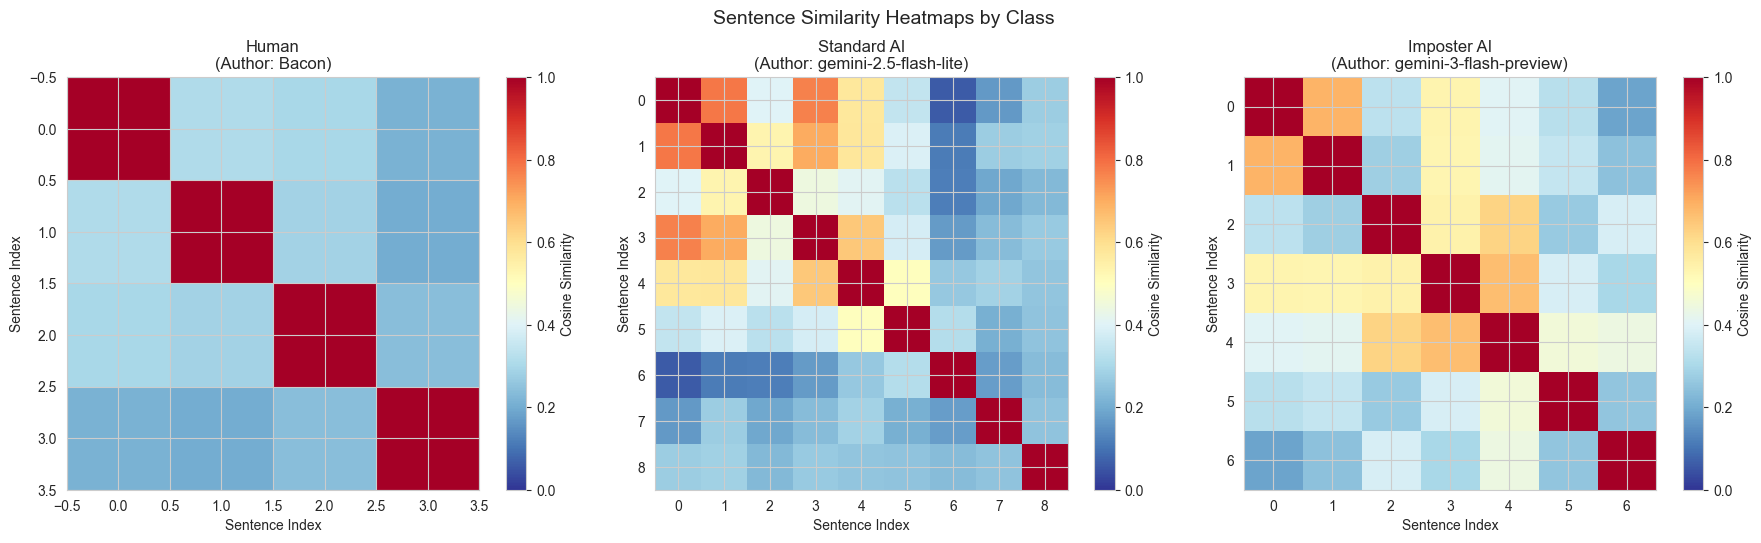

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

class_names = {1: 'Human', 2: 'Standard AI', 3: 'Imposter AI'}

for i, cls in enumerate([1, 2, 3]):
    sample = df[df['class'] == cls].iloc[5]
    matrix = compute_similarity_matrix(sample['text'], embedder)
    
    ax = axes[i]
    im = ax.imshow(matrix, cmap='RdYlBu_r', vmin=0, vmax=1)
    ax.set_title(f'{class_names[cls]}\n(Author: {sample["author"]})', fontsize=12)
    ax.set_xlabel('Sentence Index')
    ax.set_ylabel('Sentence Index')
    plt.colorbar(im, ax=ax, label='Cosine Similarity')

plt.suptitle('Sentence Similarity Heatmaps by Class', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

Compute features for all texts.

In [7]:
all_features = []
all_matrices = []
valid_indices = []

for idx, row in tqdm(df.iterrows(), total=len(df)):
    matrix = compute_similarity_matrix(row['text'], embedder)
    if matrix is not None:
        features = extract_matrix_features(matrix)
        if features is not None:
            all_features.append(features)
            all_matrices.append(matrix)
            valid_indices.append(idx)

features_df = pd.DataFrame(all_features)
df_valid = df.loc[valid_indices].reset_index(drop=True)
df_valid = pd.concat([df_valid, features_df], axis=1)

print(f'{len(df_valid)} texts with features')

100%|██████████| 1508/1508 [00:24<00:00, 62.42it/s]

1502 texts with features


Average heatmaps per class (normalized to 10x10).

In [8]:
def get_normalized_matrix(text, embedder, target_size=10):
    matrix = compute_similarity_matrix(text, embedder, max_sentences=20)
    if matrix is None:
        return None

    from scipy.ndimage import zoom
    zoom_factor = target_size / matrix.shape[0]
    resized = zoom(matrix, zoom_factor, order=1)
    return resized[:target_size, :target_size]

avg_matrices = {}

for cls in [1, 2, 3]:
    class_df = df_valid[df_valid['class'] == cls]
    matrices = []

    for _, row in class_df.head(50).iterrows():
        m = get_normalized_matrix(row['text'], embedder, target_size=10)
        if m is not None:
            matrices.append(m)

    avg_matrices[cls] = np.mean(matrices, axis=0)
    print(f'  Class {cls}: {len(matrices)} matrices')

  Class 1: 50 matrices
  Class 2: 50 matrices
  Class 3: 50 matrices


Structural fingerprints: average patterns + AI-Human difference.

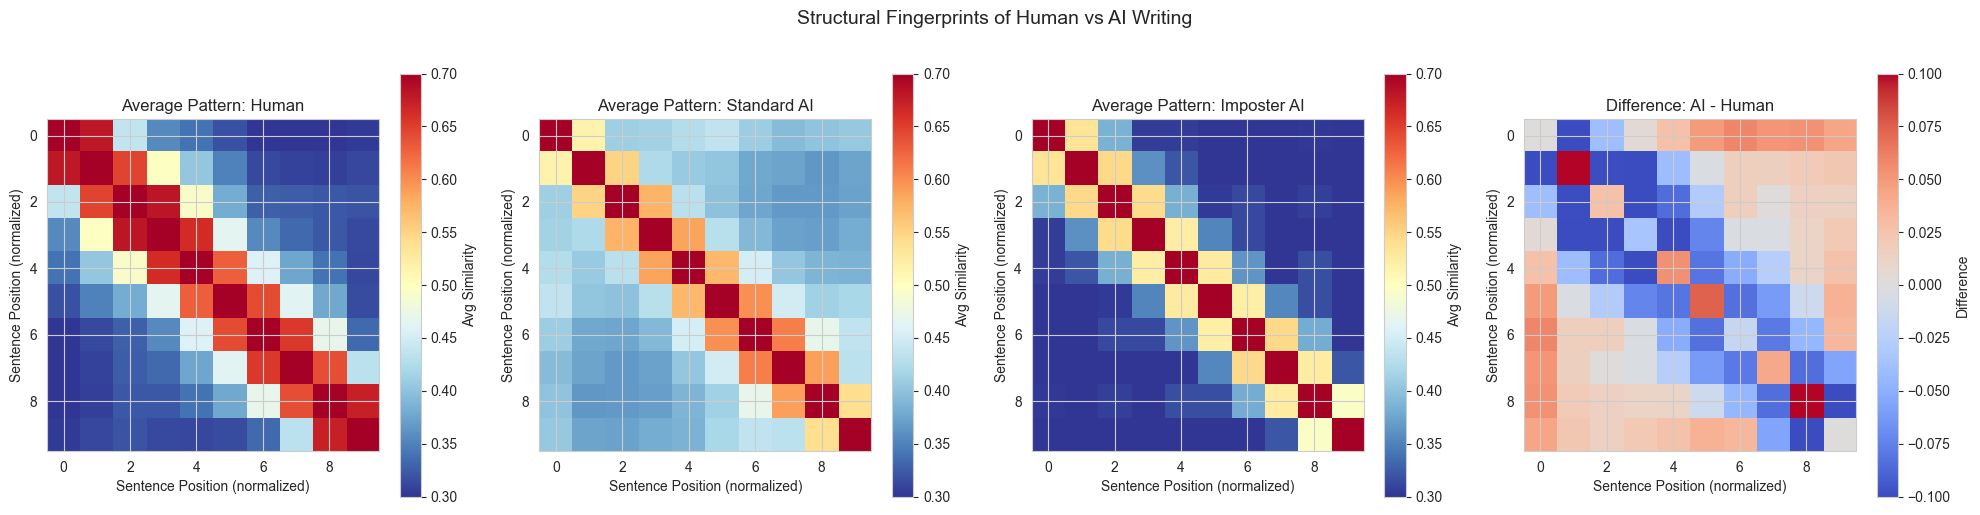

In [9]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

class_names = {1: 'Human', 2: 'Standard AI', 3: 'Imposter AI'}

for i, cls in enumerate([1, 2, 3]):
    ax = axes[i]
    im = ax.imshow(avg_matrices[cls], cmap='RdYlBu_r', vmin=0.3, vmax=0.7)
    ax.set_title(f'Average Pattern: {class_names[cls]}', fontsize=12)
    ax.set_xlabel('Sentence Position (normalized)')
    ax.set_ylabel('Sentence Position (normalized)')
    plt.colorbar(im, ax=ax, label='Avg Similarity')

ax4 = axes[3]
diff = (avg_matrices[2] + avg_matrices[3]) / 2 - avg_matrices[1]
im = ax4.imshow(diff, cmap='coolwarm', vmin=-0.1, vmax=0.1)
ax4.set_title('Difference: AI - Human', fontsize=12)
ax4.set_xlabel('Sentence Position (normalized)')
ax4.set_ylabel('Sentence Position (normalized)')
plt.colorbar(im, ax=ax4, label='Difference')

plt.suptitle('Structural Fingerprints of Human vs AI Writing', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## Classification
Random Forest on structural features. Stratified split by class + author.

In [10]:
df_valid['strat_key'] = df_valid['class'].astype(str) + '_' + df_valid['author'].astype(str)

train_val, test = train_test_split(df_valid, test_size=0.15, stratify=df_valid['strat_key'], random_state=42)
train, val = train_test_split(train_val, test_size=0.15/0.85, stratify=train_val['strat_key'], random_state=42)

print(f'Train: {len(train)}, Val: {len(val)}, Test: {len(test)}')

train[['id', 'class', 'topic', 'author']].to_parquet('train.parquet', index=False)
val[['id', 'class', 'topic', 'author']].to_parquet('validate.parquet', index=False)
test[['id', 'class', 'topic', 'author']].to_parquet('test.parquet', index=False)

Train: 1050, Val: 226, Test: 226


Train RF, evaluate on validation set.

In [11]:
feature_cols = ['n_sentences', 'diag1_mean', 'diag1_std', 'diag2_mean',
                'upper_tri_mean', 'upper_tri_std', 'block_mean', 'block_std',
                'gradient_mean', 'gradient_max', 'symmetry']

X_train = train[feature_cols].values
y_train = (train['class'] > 1).astype(int).values

X_val = val[feature_cols].values
y_val = (val['class'] > 1).astype(int).values

X_test = test[feature_cols].values
y_test = (test['class'] > 1).astype(int).values

model = RandomForestClassifier(n_estimators=200, max_depth=6, random_state=42)
model.fit(X_train, y_train)

y_val_prob = model.predict_proba(X_val)[:, 1]
y_val_pred = model.predict(X_val)

val_auc = roc_auc_score(y_val, y_val_prob)
val_acc = accuracy_score(y_val, y_val_pred)
print(f'Validation ROC AUC: {val_auc:.4f}')
print(f'Validation Accuracy: {val_acc:.4f}')

Validation ROC AUC: 0.8621
Validation Accuracy: 0.7876


Feature importance ranking.

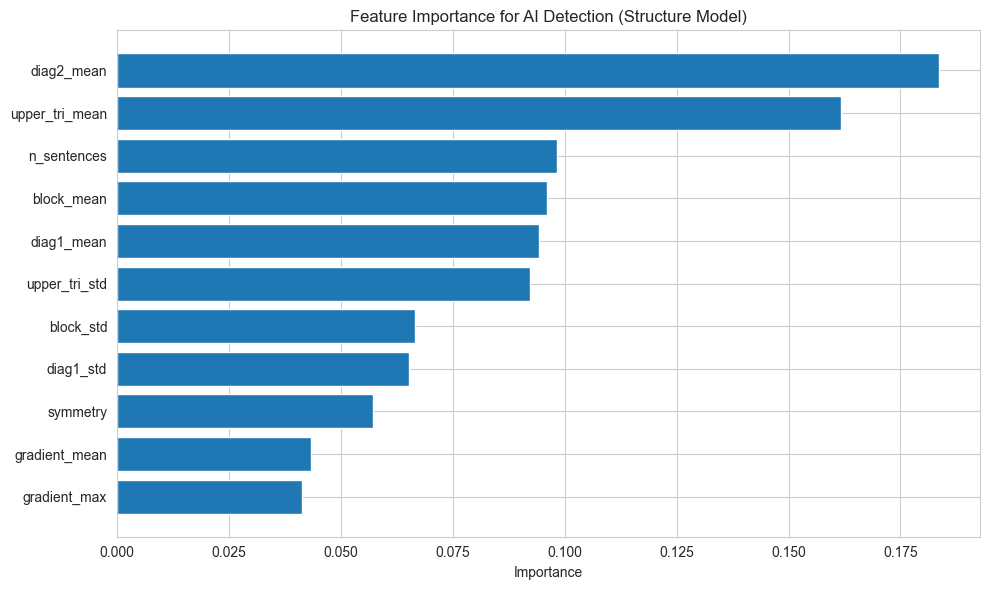

In [12]:
importance = model.feature_importances_
importance_df = pd.DataFrame({'feature': feature_cols, 'importance': importance})
importance_df = importance_df.sort_values('importance', ascending=True)

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(importance_df['feature'], importance_df['importance'])
ax.set_xlabel('Importance')
ax.set_title('Feature Importance for AI Detection (Structure Model)')
plt.tight_layout()
plt.show()

High-confidence AI detections on validation set.

In [13]:
val_results = val.copy()
val_results['prob_ai'] = y_val_prob
val_results['pred'] = y_val_pred
val_results['actual_binary'] = y_val

high_conf_ai = val_results[(val_results['prob_ai'] > 0.9) & (val_results['actual_binary'] == 1)].head(3)

for _, row in high_conf_ai.iterrows():
    print(f'ID: {row["id"]}, Class: {row["class"]}, P(AI): {row["prob_ai"]:.3f}')
    print(f'  diag1_mean: {row["diag1_mean"]:.3f} (adjacent similarity)')
    print(f'  upper_tri_mean: {row["upper_tri_mean"]:.3f} (overall coherence)')
    print(f'  block_std: {row["block_std"]:.3f} (block variation)')
    print(f'  gradient_max: {row["gradient_max"]:.3f} (structural change)')

ID: 6a57b50f-4564-4e5d-8aff-a28352e16481, Class: 3, P(AI): 0.955
  diag1_mean: 0.456 (adjacent similarity)
  upper_tri_mean: 0.464 (overall coherence)
  block_std: 0.048 (block variation)
  gradient_max: 0.163 (structural change)
ID: 53cb4fcf-0320-4f44-8537-3908e1ba765b, Class: 3, P(AI): 0.946
  diag1_mean: 0.367 (adjacent similarity)
  upper_tri_mean: 0.363 (overall coherence)
  block_std: 0.060 (block variation)
  gradient_max: 0.148 (structural change)
ID: 08e62bd1-185d-4fd9-98e6-14a1a0808a74, Class: 2, P(AI): 0.947
  diag1_mean: 0.450 (adjacent similarity)
  upper_tri_mean: 0.438 (overall coherence)
  block_std: 0.057 (block variation)
  gradient_max: 0.106 (structural change)


Feature distributions by class.

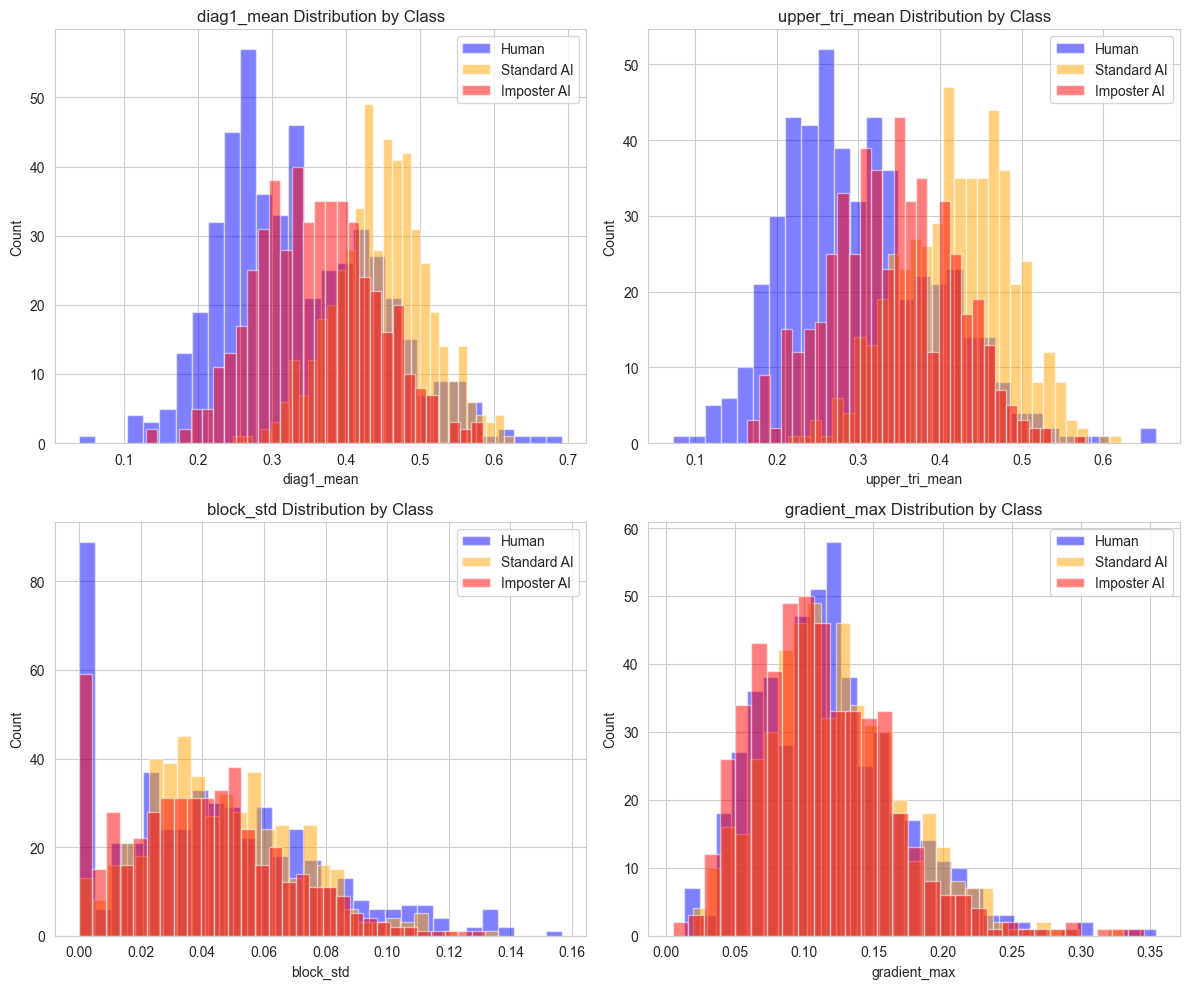

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for i, feat in enumerate(['diag1_mean', 'upper_tri_mean', 'block_std', 'gradient_max']):
    ax = axes.flatten()[i]
    
    for cls, label, color in [(1, 'Human', 'blue'), (2, 'Standard AI', 'orange'), (3, 'Imposter AI', 'red')]:
        mask = df_valid['class'] == cls
        ax.hist(df_valid[mask][feat], bins=30, alpha=0.5, label=label, color=color)
    
    ax.set_xlabel(feat)
    ax.set_ylabel('Count')
    ax.legend()
    ax.set_title(f'{feat} Distribution by Class')

plt.tight_layout()
plt.show()

## Test set

Test ROC AUC: 0.8751
Test Accuracy: 0.8186


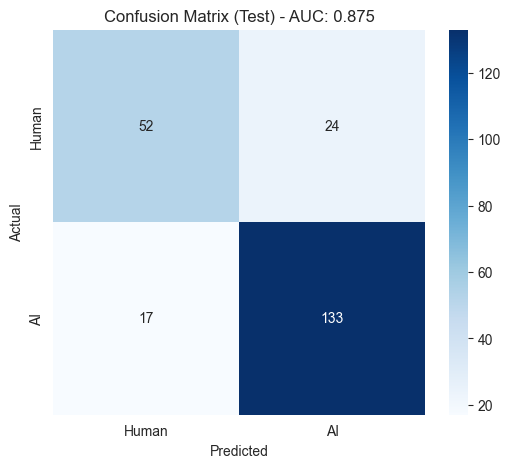

In [15]:
y_test_prob = model.predict_proba(X_test)[:, 1]
y_test_pred = model.predict(X_test)

test_auc = roc_auc_score(y_test, y_test_prob)
test_acc = accuracy_score(y_test, y_test_pred)
print(f'Test ROC AUC: {test_auc:.4f}')
print(f'Test Accuracy: {test_acc:.4f}')

cm = confusion_matrix(y_test, y_test_pred)
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['Human', 'AI'], yticklabels=['Human', 'AI'])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title(f'Confusion Matrix (Test) - AUC: {test_auc:.3f}')
plt.show()